<div style="text-align: right">  
Notebook by Timothy Tiggeloven en Marthe Wens <br>
Water harvesting model by Timothy Tiggeloven <br>
CBA and Risk analysis by Marthe Wens </div>

Water Risk Practicum: Evaluating the effects of WHS
====================

## Introduction
For this exercise, imagine you live in rural, semi-arid place and have a household to run. You need <span style="color:red">85.86 liters</span> of water per week per person for your household - domestic water demand. You want to implement a new water harvesting technique and want to know the effect of climate change on your investment. Therefore, you need to analyse if your investment is feasible. In order to analyse this, you have a water storage model (this script) and meteorological data (csv file) at your disposal. The water storage model is a simple model in which water can be harvested and stored during a period of time. The model runs on a daily time step basis in which water enters the system through direct precipitation or runoff and leaves the system through usage of water and evaporation. Two types of water harvesting structures (WHS) will be analysed in this practical; a cistern and an open pond. Dimensions and usage can be altered in the script. For cistern storage, the evaporation is assumed to be zero, however it is more expensive to build <a href="https://doi.org/10.1016/j.jaridenv.2015.02.019">(Lasage & Verburg, 2015)</a>. The model takes input of a comma-separated meteorological data file in which data of the years, months, days, precipitation and temperature of the chosen region is found. The following paragraphs are a guide to the script.
</div>

The learning goals of this practical are:
* Gain insight in working with small scale water harvesting systems
* Work with a python-based model
* Learn simple time series analysis in Python
* calculate water risk related terms like cost benefit analysis and expected losses

<div style="text-align: justify">During this practical we will focus on basic time series analysis and list operations in Python. While programming, you will come across errors in your script. Try first to read the errors and understand what went wrong. A lot of the times it’s just a typo. When you are in doubt about the error, it might help to google the error message and maybe add the function you used to narrow the searches down. A very helpful site that will pop up in google is stackoverflow in which similar problems are solved by the stackoverflow community.
<br><br>

In [1]:
# import working modules

import math
import numpy as np
import os
import pandas as pd
import sys

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

## Load input and declare variables

<div style="text-align: justify"> In this step we are going to load the input variables with package called Pandas /n
Further we assign values to declare the characteristics of the WHS, and we specify the the region of interest.
</div>

1. Load meteorological dataset
<br>  HINT: Make sure the input files and the python script are in the same folder. Reading csv files is done with the pandas read_csv function. Be sure to specify the right csv file as input file and assign a suitable name for the output file when you make adjustments to the variables.

In [2]:
# Assign input and output file !!! select the correct ‘historical’ input file, that is not with ‘rcp’ in the name
input_file = "C:/Users/marth/Desktop/ASALI training/Practica/input/input_malawi_mulanje_region.csv" 

years = 30  # specify lenght of the dataset

try:
    df = pd.read_csv(input_file)
except FileNotFoundError as e:
    print("\nFileNotFoundError: %s" % e)
    print("\nCheck input file name\n")
    sys.exit(1)

data = df[['Year', 'Month', 'Day', 'Precipitation', 'Temperature']].copy()

data['Time'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
Time = data['Time'].values.flatten()
data['Day of year'] = data['Time'].dt.dayofyear
data = data.set_index('Time')

2. Define the area-specific characteristics.
<br> The 'global variables' to assign are the water usage, runoff coefficient, threshold and latitude in degrees of selected region. 

In [3]:
# global variables
demand = 85.86                 # demand of water per week per person [L]
HH = 5.8                       # mean persons per household in Ethiopia
field = 1000                   # average farm field size [m3]
num = 10                       # number of households that use open pond
ROC = 0.72                     # runoff coefficient [-]
threshold = 0.01               # minimum rainfall before runoff occurs [m3]
lat = -1.1315313               # latitude of location [•]

3. Define the size of the reservoirs for open pond and cistern.
Water Harvesting Structures -specific variables can be assigned. Experiment with these values to get the maximum efficiency.

In [4]:
# cistern variables
cap_cis = 50                   # capacity of cistern [m3]
catchment_cis = 3000            # catchment size of cistern [m2]
depth_cis = 5                  # depth of cistern [m]
inlet_cis = cap_cis/depth_cis  # inlet of cistern [m2]

In [5]:
# open pond variables
cap_op = 500                    # capacity of open pond [m3]
catchment_op = 30000           # catchment size of open pond [m2]
depth_op = 5                   # depth of open pond [m]
inlet_op = cap_op/depth_op     # inlet of open pond [m2]

## Functions
<div style="text-align: justify">
The model makes use of two functions, a water storage calculation and an evaporation calculation. They are specified in the beginning of the script, and 'called'(i.e. used) later in the calculations.
</div>

1. Evaporation calculation
<br><br>
<div style="text-align: justify"> Thornthwaite evaporation is calculated with the evap_calc function and takes temperature, number of the day of the year, number of the day of the month, month number and year as input. Because the Thornthwaite evaporation is dependent on the average length of the day and a heat function based on mean monthly temperatures extra sets of codes are used. The Thornthwaite evaporation is calculated with the following formula:
<br><br>
$$PE=16 * \frac{L}{12*M} \left(\frac{10Ta}{I}\right)^{α}$$
<br>
where L is the average length of the day, M the number of days in the month, T a the average daily temperature, I the heat index and α a function based on the heat index (Thornthwaite, 1948). Potential evaporation ( P E ) is calculated in mm day-​ 1​.</div>

In [6]:
# Evaporation calculation script (NO CHANGES NEEDED)
def evap_calc(data):
    
    # Apply sunrise equation in order to calculate the average length of the day cfr. (Allen et al., 1998)
    omega = lat * math.pi / 180
    data['Delta'] = 0.409 * np.sin(2 * data['Day of year'] * np.pi / 365 - 1.39)
    data['ws'] = np.arccos(-np.tan(omega) * np.tan(data['Delta']))
    data['daylight'] = 24 * data['ws'] / np.pi
    data = data.drop(['Delta', 'ws'], axis=1)

    # Calculate average temperature data per month
    Month_data = data['Temperature'].resample("M").mean().to_frame()

    # Assign number of days in a month for the specific months in data        
    data['days per month'] = data.index.to_series().dt.daysinmonth

    # Calculate heat index function, which depends on the 12 monthly mean temperatures  
    Month_data['Heat index'] = pow((0.2 * Month_data['Temperature']), 1.514)
    Year_data = Month_data['Heat index'].resample("A").sum().to_frame()
    
    # Convert monthly heat index to daily values
    Year_data['Year'] = Year_data.index.to_series().dt.year
    data = data.merge(Year_data, how='left', on='Year')

    #  Thornthwaite evaporation can be calculated per day
    TW = []
    for temp, dl, dpm, hi in zip(data['Temperature'].values.flatten(),
                          data['daylight'].values.flatten(),
                          data['days per month'].values.flatten(),
                          data['Heat index'].values.flatten()):
        
        # Calculate the alpha function, depended on heat index
        alpha = ((6.75 * pow(10, -7)) * pow(hi, 3) - (7.71 * pow(10, -5)) *
                 pow(hi, 2) + (1.7912 * pow(10, -2)) * hi + 0.49239)

        # Check if temperature is extreme
        if temp > 26:   # If daily average temperature is higher than 26 a different equation is used
            PET = (dl / (12 * dpm)) * (-415.85 + 32.24 * temp - pow((0.43 * temp), 2))
        elif temp < 0:  # If temperature is below zero, evaporation is assumed to be close to zero
            PET = 0.0001
        else:        # Normal Thornthwaite equation
            PET = 16 * (dl / (12 * dpm)) * pow((10 * temp / hi), alpha)
        TW.append(PET)
    
    return TW

2. Water storage calculation function
<br>
<br>
<div style="text-align: justify"> The storage calculation function calculates the amount of water available in the WHS (cistern or open pond). It takes precipitation, evaporation and the characteristics of the WHS as input. <br> Water inflow in the WHS can occur in two ways: by rainfall and by runoff. Rainfall inflow only occurs in open ponds. Runoff inflow only occurs if the assigned threshold is met and calculated by multiplying the catchment size with precipitation and the runoff coefficient. <br> Water outflow happens through evaporation. Evaporation in this script is calculatend following the Thornthwaite function (see function above), but you can also use the Penman-Monteith evaporation function instead. Evaporation happens only for open ponds.  <br> The list E_list keeps track of the amount of storage water evaporated during the period of the model run. After assessing the inflow and outflow, one can calculate the real amount of water that can be harvested. Then, extraction for household use is taken into account.</div>

In [7]:
# water storage calculation script (NO CHANGES NEEDED)
def storage_calc(prec, evap, pot_use, WHS, cap, catchment, depth, inlet):

    EvtActual_list, storage_list, usage_list, waterflux_list = [], [], [], []
    stored = 0 # Initial water storage is zero
    used = 0  # Initial water usage is zero
    
    # calculate storage and usage of WHS per time step (day)
    for e, p in zip(evap, prec):
        
        # Evaporation and precipitation is divided by 1000 to transform mm/day to m/day 
        Evt = e / 1000
        Pr  = p / 1000
        
        # this variable keeps track of the flux of water that day
        waterflux = 0

        # Water inflow from direct precipitation is only assigned if WHS is open pond
        if WHS == 'open pond':
            waterflux += (inlet * Pr)
            stored += (inlet * Pr)
        # Water inflow from Runoff only takes place if the assigned threshold is met.
        if Pr > threshold:
            waterflux += (catchment * Pr * ROC)
            stored += (catchment * Pr * ROC)
        
        # Water outflow through evaporation (remember: zero if cistern)
        if stored < (Evt * inlet): # If evaporation is higher than the amount of water in WHS, the full storage water will evaporate
            EvtActual_list.append(stored)
            waterflux -= stored
            stored = 0
            
        else: # No limits on evaporation here
            EvtActual_list.append(Evt)
            waterflux -= (Evt * inlet)
            stored -= (Evt * inlet)
        
        # Check whether the storage will not succeed capacity 
        if stored > cap:
            waterflux -= (stored - cap)
            stored = cap
      
        # Substract household water usage from the WHS storage
        if stored < pot_use:
            used = stored
            stored = 0
        else:
            used = pot_use
            stored -= pot_use

        # save the daily storage and use data
        storage_list.append(stored)
        usage_list.append(used)
        waterflux_list.append(waterflux)

    output = Storage_output(storage_list, usage_list, EvtActual_list, waterflux_list)

    return output

In [8]:
# extra function to create an object to store variables in
class Storage_output(object):

    def __init__(self, storage, usage, evaporation, waterflux):
        self.storage = storage
        self.usage = usage
        self.evaporation = evaporation
        self.waterflux = waterflux

## Calculate the water storage in, and usage from the WHS

First, the potential daily water use of the household needs to be calculated. Then, the functions - specified before- are called and data is passed throught them to calculate the daily storage of the two water harvesting systems. 

In [9]:
# Calculate the daily water demand (the usage potential) in m3
potential_usage = (HH * num) * (demand / 7) / 1000
print('Water demand : ', potential_usage)

Water demand :  0.7114114285714286


In [10]:
# Calculate the potential evaporation using the Thornthweite function
evap_data = evap_calc(data)
prec_data = data['Precipitation'].values.flatten()
print('Average annual potential evaporation (mm) : ',np.sum(evap_data)/years)
print('Average annual precipitation (mm) : ',np.sum(prec_data)/years)

Average annual potential evaporation (mm) :  2367.60506898746
Average annual precipitation (mm) :  1236.8098681257334


In [11]:
# Calculate the water storage and actual water usage from the WHS

# Evaporation is assigned zero for cistern storage
evap_cis = [0 * i for i in evap_data]
output_cis = storage_calc(prec_data, evap_cis, potential_usage, "cistern", cap_cis, catchment_cis, depth_cis, inlet_cis)

# Because the storage function returns an ‘object’ (see storage_output function); 
# storage, usage and evaporation can easily be accessed. 
# A statement like "output_op.usage" will thus give you the open pond water usage.
print('Average annual water storage in cistern (m3) : ',np.sum(output_cis.storage)/years)

#Thornthwaite Evt values assigend for open pond 
evap_op = evap_data
output_op  = storage_calc(prec_data, evap_op, potential_usage, "open pond", cap_op, catchment_op, depth_op, inlet_op)

print('Average annual water storage in pond (m3) : ',np.sum(output_op.storage)/years)

Average annual water storage in cistern (m3) :  10668.051271554898
Average annual water storage in pond (m3) :  169316.1925684992


In [12]:
# Now save all the newly generated information in our data directory
data['potentialevaporation'] = evap_data
data['cis_storage']          = output_cis.storage
data['cis_usage']            = output_cis.usage
data['cis_evaporation']      = output_cis.evaporation
data['cis_waterflux']        = output_cis.waterflux
data['op_storage']           = output_op.storage
data['op_usage']             = output_op.usage
data['op_evaporation']       = output_op.evaporation
data['op_waterflux']         = output_op.waterflux
data['direct rain']          = data['Precipitation'] / 1000 * 100  ###### WHY *10 ?

# Calculate WHS effectiveness

Analyse the effectiveness of the WHS by evaluating the actual use and water demand. <br> Add a script to calculate the average yearly extracted water and effectiveness and the water shortage that is not mitigated, even using the WHS structures. The effectiveness of the WHS can be calculated by dividing the total water demand over the analyzed period into the actual extracted water from the reservoir for household use.
The remaining water shortage can be calculated as the total number of days the reservoir contains too little water to meet this water use.

In [13]:
## write here your code to calculate the average yearly water extraction (hint: use np.sum, np.mean, len())

YE_op = np.sum(output_op.usage) / len(output_op.usage) * 365
YE_cis = np.sum(output_cis.usage) / len(output_cis.usage) * 365

print(f'Yearly extracted water of open pond: {YE_op} m3 ')
print(f'Yearly extracted water of cistern: {YE_cis} m3 ')

Yearly extracted water of open pond: 259.52298004146087 m3 
Yearly extracted water of cistern: 214.10722233862168 m3 


In [14]:
# write here your code to calculate the water effectiveness (hint: use np.sum, np.mean, len())

effect_op = np.sum(output_op.usage) / (len(output_op.usage) * potential_usage)
effect_cis = np.sum(output_cis.usage) / (len(output_cis.usage) * potential_usage)

print(f'Effectiveness of open pond: {effect_op} %')
print(f'Effectiveness of cistern: {effect_cis} %')

Effectiveness of open pond: 0.9994524048553438 %
Effectiveness of cistern: 0.8245511755030197 %


In [15]:
# write here your code to calculate the water shortage days (Hint: use np.where function or make use of a loop)

# dry days open pond
dry_days_op = 0
for i in output_op.usage:
    if i < potential_usage:
        dry_days_op += 1

# dry days cistern
dry_days_cis = 0
for i in output_cis.usage:
    if i < potential_usage:
        dry_days_cis += 1
        
print(f'Average amount of days with depleted water storage per year - open pond: {dry_days_op/years}')
print(f'Average amount of days with depleted water storage per year - cistern:  {dry_days_cis/years}')

Average amount of days with depleted water storage per year - open pond: 0.2
Average amount of days with depleted water storage per year - cistern:  64.63333333333334


# Calculate WHS efficiency
Analyse the economic efficiency of the WHS by evaluating their costs and benefits. <br> The cost benefit ratio represents the ratio between the total benefits and the total costs of a measure. The net present value represents the difference between the present value of the future cash flows from an investment and the amount of investment and is a measure to evaluate and compare financial products with cash flows spread over time and. A zero net present value means the project repays original investment plus the required rate of return. A positive net present value means a better return, and a negative net present value means a worse return, than the return from zero net present value. The formula to calculate the net present value is as follows: <br><br>
$$NPV =  \sum_{t=1}^N \frac{Ct - Bt}{\left(1 + dr\right)^{t}}$$
<br>
with t the time of the cash flow, N the total number of years, Bt and Ct the respective benefits and costs at a certain time and dr the discount rate. <dr> For the exercise, we assume the lifetime of the structures to be 30 years (total period of input data).

In [16]:
# Specify the time horizon and discount rate of the CBA
dr = 0.04

In [17]:
# Resample usage to yearly values in new file
yearly_usage_cis = data[['cis_usage']].resample("Y").sum().values
yearly_usage_op = data[['op_usage']].resample("Y").sum().values

1.  Calculate costs of construction and costs per cubic meter harvested water <br>

The investment costs per m3​ of storage capacity for an open pond is 20.47 dollar, and for a
cistern 32.28 dollar. 
The yearly maintenance costs per m3​ of storage capacity for an open pond is 0.31 dollar, and for a
cistern 0.19 dollar.

In [18]:
# write here your code to calculate the total costs 
yearlycosts_cis = np.zeros(years) + ( 0.19 * cap_cis )
yearlycosts_cis[0] = 32.28 * cap_cis
yearlycosts_op = np.zeros(years) + ( 0.31 * cap_op ) 
yearlycosts_op[0] = 20.47  * cap_op  

print(f'Yearly costs Cistern (average includes investment and maintenance): {np.mean(yearlycosts_cis)} dollar')
print(f'Yearly costs Open Pond (average includes investment and maintenance): {np.mean(yearlycosts_op)} dollar')

# write here your code to calculate the costs per m3​ of extracted water.
costs_water_op = np.sum(yearlycosts_op) / np.sum(yearly_usage_op)
costs_water_cis = np.sum(yearlycosts_cis) / np.sum(yearly_usage_cis) 
print(f'Cost of water for open pond: {costs_water_op} dollar / m3 water')
print(f'Cost of water for cistern: {costs_water_cis} dollar / m3 water')

Yearly costs Cistern (average includes investment and maintenance): 62.983333333333334 dollar
Yearly costs Open Pond (average includes investment and maintenance): 491.0 dollar
Cost of water for open pond: 1.8907239704537 dollar / m3 water
Cost of water for cistern: 0.29397932050296033 dollar / m3 water


2. Calculate benefits of harvested water <br>

To estimate the net benefit of the measure, you have to find the water price (for botteled water) in your study area and multiply it with water usage from the WHS. (Assuming otherwise you would have to buy the water you are using). 

In [19]:
# Write here your code to calculate the total benefits timeseries
waterprice = 1.4  # per m3

yearlybenefit_cis = waterprice * yearly_usage_cis 
yearlybenefit_op = waterprice * yearly_usage_op  

print(f'Yearly benefits Cistern (saved water expenditures): {np.mean(yearlybenefit_cis)} dollar')
print(f'Yearly benefits Open Pond (saved water expenditures): {np.mean(yearlybenefit_op)} dollar')

Yearly benefits Cistern (saved water expenditures): 299.9417323497716 dollar
Yearly benefits Open Pond (saved water expenditures): 363.5644392000018 dollar


3. Calculate benefit-cost ratio and net present value <br>

The BC-ratio can be calculated as the total benefits divided by the total costs, while the net present value should be calculated per year and summed, following the formula specified above.

In [20]:
# Write here your code to calculate the total BC-ratio
BCratio_cis = np.sum(yearlybenefit_cis) /  np.sum(yearlycosts_cis)
BCratio_op = np.sum(yearlybenefit_op) /  np.sum(yearlycosts_op)

print(f'Benefits / Costs ratio Cistern: {BCratio_cis}')
print(f'Benefits / Costs ratio Open Pond: {BCratio_op}')

Benefits / Costs ratio Cistern: 4.762239730348318
Benefits / Costs ratio Open Pond: 0.7404571063136492


In [21]:
# Write here your code to calculate the NPV (hint: power statement: **)
CBA_cis = np.zeros(years)
CBA_op = np.zeros(years)
for t in range(years):
    CBA_cis[t] = (yearlybenefit_cis[t] - yearlycosts_cis[t]) / (1 + dr)**t
    CBA_op[t] = (yearlybenefit_op[t] - yearlycosts_op[t]) / (1 + dr)**t
NPV_cis=np.sum(CBA_cis)
NPV_op=np.sum(CBA_op)

print(f'Net Present Value Cistern: {np.mean(NPV_cis)}')
print(f'Net Present Value Open Pond: {np.mean(NPV_op)}')

Net Present Value Cistern: 3644.915287650801
Net Present Value Open Pond: -6331.582439699076


# Calculate agricultural drought risk

Assume you use the water in the WHS to irrigate (water) the maize on your field. Using a maize vulnerability curve, you can now estimate the maize yield per year under rainfed conditions or under water harvesting conditions for the main cropping season (Ethiopia: MAMJJA; Burkina: MJJASO; Malawi: DJFMAM). This allows to estimate crop losses (in dollars, if the maize price is taken into account) hence an estimation of the expected annual damage.   

In [22]:
# Find seasonal precipitation and water storage
startmonth= -2
endmonth= 4
    
monthly_storage_cis = data[['cis_waterflux']].resample("M").sum().values
monthly_storage_op = data[['op_waterflux']].resample("M").sum().values
monthly_precipitation = data['Precipitation'].resample("M").sum().values

seasonal_storage_cis = np.zeros(years)
seasonal_storage_op = np.zeros(years)
seasonal_precipitation = np.zeros(years)
for y in range(1,years):
    seasonal_storage_cis[y] = np.nansum(monthly_storage_cis[(12*(y-1))+endmonth+1:(12*y)+endmonth]) # Storage end of season
    seasonal_storage_op[y] = np.nansum(monthly_storage_op[(12*y)+startmonth:(12*y)+endmonth])
    seasonal_precipitation[y] = np.nansum(monthly_precipitation[(12*y)+startmonth:(12*y)+endmonth]) # sum of monthly rain over season

# Convert available water to mm over the field
seasonal_available_cis = (1000 * seasonal_storage_cis / field)
seasonal_available_op = (1000 * seasonal_storage_op / field)

print(f'The average seasonal precipitation equals: {np.round(np.mean(seasonal_precipitation))} mm')
print(f'The average seasonal cistern water supply equals: {np.round(np.mean(seasonal_available_cis))} mm')
print(f'The average seasonal pond water supply equals: {np.round(np.mean(seasonal_available_op))} mm')

The average seasonal precipitation equals: 1004.0 mm
The average seasonal cistern water supply equals: 201.0 mm
The average seasonal pond water supply equals: 147.0 mm


In [23]:
# Read in the vulnerability file
# (Source vulnerability: Meng et al (2016) Growing sensitivity of maize to water scarcity under climate change; World Bank Data - FAO maize yield (kg/ha))

input_file = "C:/Users/marth/Desktop/ASALI training/Practica/input/Maizevulnerability.xlsx" 

try:
    df = pd.read_excel(input_file)
except FileNotFoundError as e:
    print("\nFileNotFoundError: %s" % e)
    print("\nCheck input file name\n")
    sys.exit(1)
vulnfile = df#[['Rain', 'Malawi']].copy().rename({'Malawi': 'Yield'}, axis=1)

In [24]:
# Assuming 800mm is enough to have full yield, calculate irrigation needs and total available water per season
cropwater_available_rain = np.zeros(years)
cropwater_available_cis = np.zeros(years)
cropwater_available_op = np.zeros(years)

for y in range(years):
    cropwater_available_rain[y] = seasonal_precipitation[y]
    cropwater_available_cis[y] = seasonal_precipitation[y]
    cropwater_available_op[y] = seasonal_precipitation[y]
    if seasonal_precipitation[y] < 900:
        if (900 - seasonal_precipitation[y] ) > seasonal_available_cis[y]:             
            cropwater_available_cis[y] = seasonal_precipitation[y] + seasonal_available_cis[y]
        else: # if plenty: irrigate till 800m is achieved
            cropwater_available_cis[y] =  900
        if (900 - seasonal_precipitation[y]) > seasonal_available_op[y]:
            cropwater_available_op[y] = seasonal_precipitation[y] + seasonal_available_op[y]
        else: # if plenty: irrigate till 800m is achieved
            cropwater_available_op[y] =  900

# Calculate mean availability
print(f'The average seasonal crop water availability equals: {np.mean(cropwater_available_rain)} mm')
print(f'The average seasonal crop water available with cistern irrigation equals: {np.mean(cropwater_available_cis)} mm')
print(f'The average seasonal crop water available with pond irrigation equals: {np.mean(cropwater_available_op)} mm')

The average seasonal crop water availability equals: 1003.9011063900333 mm
The average seasonal crop water available with cistern irrigation equals: 1049.5090038550666 mm
The average seasonal crop water available with pond irrigation equals: 1041.9473692609772 mm


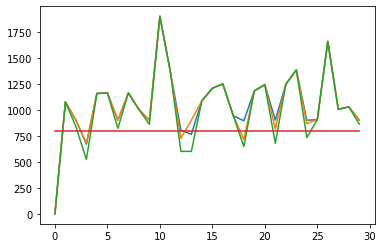

In [25]:
plt.plot(cropwater_available_cis)
plt.plot(cropwater_available_op)
plt.plot(cropwater_available_rain)
plt.plot(np.zeros(cropwater_available_rain.shape)+800)
plt.show()

In [39]:
# Check crop yield per year

yieldpotential = vulnfile['Malawi'][vulnfile['Rain']==800]

cropyield_rain = np.zeros(years)
cropyield_cis = np.zeros(years)
cropyield_op = np.zeros(years)
for y in range(years):
    cropwater_rain = min(vulnfile['Rain'], key=lambda x:abs(x-cropwater_available_rain[y])) # find nearst neighbour
    cropyield_rain[y] = vulnfile['Malawi'][vulnfile['Rain']==cropwater_rain] # assign yield based on vulnfile
    cropwater_cis = min(vulnfile['Rain'], key=lambda x:abs(x-cropwater_available_cis[y])) # find nearst neighbour
    cropyield_cis[y] = vulnfile['Malawi'][vulnfile['Rain']==cropwater_cis] # assign yield based on vulnfile
    cropwater_op= min(vulnfile['Rain'], key=lambda x:abs(x-cropwater_available_op[y])) # find nearst neighbour
    cropyield_op[y] = vulnfile['Malawi'][vulnfile['Rain']==cropwater_op] # assign yield based on vulnfile

In [28]:
# Check crop losses and expected annual dammage (i.e. average annual crop loss in usd)
cropprice = 3 #dollar per kg
croploss_rain = cropprice * (yieldpotential.values - cropyield_rain[1:])
croploss_rain[croploss_rain<0]=0
EAD_rain = np.mean(croploss_rain) 
print(f'The expected annual agricultural damage equals: {EAD_rain} dollar')
croploss_cis = cropprice * (yieldpotential.values - cropyield_cis[1:])
croploss_cis[croploss_cis<0]=0
EAD_cis = np.mean(croploss_cis) 
print(f'The expected annual agricultural damage with cistern equals: {EAD_cis} dollar')
croploss_op = cropprice * (yieldpotential.values - cropyield_op[1:])
croploss_op[croploss_op<0]=0
EAD_op = np.mean(croploss_op) 
print(f'The expected annual agricultural damage with open pond equals: {EAD_op} dollar')

The expected annual agricultural damage equals: 966.8006379310343 dollar
The expected annual agricultural damage with cistern equals: 609.50475 dollar
The expected annual agricultural damage with open pond equals: 651.5395603448276 dollar


In [30]:
# Check cost efficiency
cis = (EAD_rain - EAD_cis) - np.mean(yearlycosts_cis)
print(f'The cost efficiency of cisterns as drought mitigation measure equals: {cis} dollar')
op = (EAD_rain - EAD_op) - np.mean(yearlycosts_op)
print(f'The cost efficiency of open ponds as drought mitigation measure equals: {op} dollar')

The cost efficiency of cisterns as drought mitigation measure equals: 294.312554597701 dollar
The cost efficiency of open ponds as drought mitigation measure equals: -175.73892241379326 dollar


Saving and plotting  data 
===========================
Output is written to a csv file. Plots are made in this script.
<br>
The goal is to make a graph with the investment per m3​ of extracted water for your location in relation to the percentage of the year water is available in the system on average for the whole analyzed period. This can either be done by adding script to the program (adding more instances of storage_calc() with different input values), or by using the output files in, for example, Excel. At the bottom of this document several functions are listed which you can use to add to the program.

In [31]:
# make pandas data frame with headers and save data frame to csv (here you can add whatever you want to save to excel)
headers = ["Storage cistern [m3]", "Storage open pond [m3]",
           "Extracted water cistern [m3]", "Extracted water open pond [m3]"]


output_data = pd.concat([data, pd.DataFrame(np.column_stack([
                                                output_op.storage,
                                                output_cis.storage,
                                                output_op.usage,
                                                output_cis.usage]), 
                        index=data.index, columns=headers)], axis=1)

# Change name of output file per run, so you can save different situations 
output_file = "myresults.xlsx" 
output_data.to_excel(output_file)

In [41]:
# Here, a function is made to plot precipitation with the water storage of the WHS. 

def WHSplot(prec, st1, st2, x):
    width = 0.8
    fig = plt.figure(figsize=(20, 12))

    # Fig 1
    ax1 = fig.add_subplot(211)
    plt.xticks(rotation=45)

    ax1.set_title('Cistern storage', fontsize=18)
    ax1.bar(x, prec, width, label='Precipitation')
    ax1.set_ylabel('Rainfall [$mm$]', fontsize=10)
    ax1.set_ylim(0, 100)
    ax1.legend(loc='upper left', shadow=True)
    ax1.tick_params(axis='both', labelsize=10)

    ax2 = ax1.twinx()
    ax2.plot(x, st1, 'y', label='Water stored')
    ax2.set_ylabel('Storage [$m^3$]', fontsize=10)
    ax2.set_ylim(0, cap_cis)
    ax2.legend(loc='upper left', shadow=True)
    ax2.tick_params(axis='both', labelsize=10)

    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles, labels, loc='upper left', fontsize=8)
    handles, labels = ax2.get_legend_handles_labels()
    ax2.legend(handles, labels, loc='upper right', fontsize=8)
    
    # Fig 2
    ax3 = fig.add_subplot(212)
    plt.xticks(rotation=45)
    
    ax3.set_title('Open pond storage', fontsize=18)
    ax3.bar(x, prec, width, label='Precipitation')
    ax3.set_ylabel('Rainfall [$mm$]', fontsize=10)
    ax3.set_ylim(0, 100)
    ax3.legend(loc='upper left', shadow=True)
    ax3.tick_params(axis='both', labelsize=10)

    ax4 = ax3.twinx()
    ax4.plot(x, st2, 'y-', label='Water stored')
    ax4.set_ylabel('Storage [$m^3$]', fontsize=10)
    ax4.set_ylim(0, cap_op)
    ax4.legend(loc='upper left', shadow=True)
    ax4.tick_params(axis='both', labelsize=10)

    handles, labels = ax4.get_legend_handles_labels()
    ax4.legend(handles, labels, loc='upper right', fontsize=8)
    handles, labels = ax3.get_legend_handles_labels()
    ax3.legend(handles, labels, loc='upper left', fontsize=8)
    
    fig.savefig("WHS.png", bbox_inches='tight', dpi=300)
    plt.tight_layout()
    plt.show()

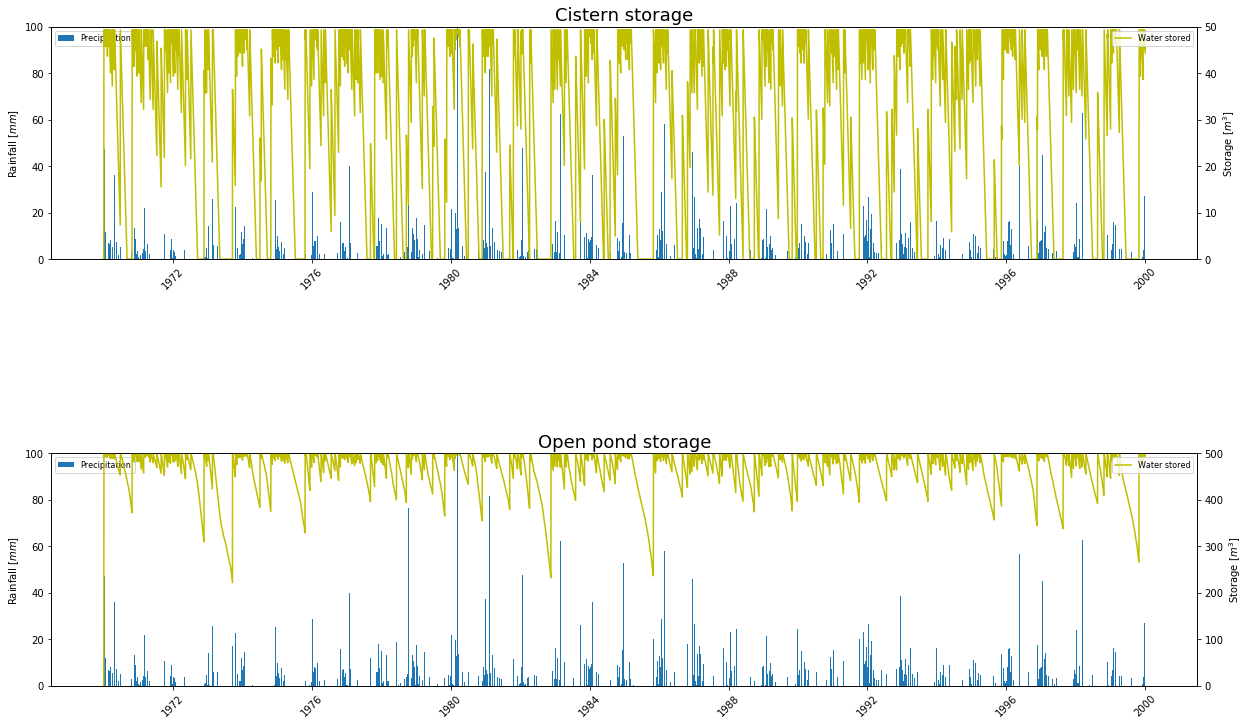

In [42]:
# Code to create the plot
# Loading might take a while as there are more than 10.000 data points.
WHSplot(prec_data, output_cis.storage, output_op.storage, Time)

# Automating the script 

Generate the following information for at least 5 model runs with different values for the capacity of the reservoir (both pond and cistern): The total costs of investment and maintenance per m3​ of extracted water and the percentage of the days of the period the system contains water. Plot these results in a graph for each WHS on the y- and x-axis respectively. If you want to do this in Python you can use, duplicate and fill in lines after assignment 6 in the script.

In [34]:
# Make for the climate scenario the script available with completed run calculations and plots

run1_cis = storage_calc(prec_data, evap_data, potential_usage, "cistern", 25, 300, 2, 150)
run2_cis = storage_calc(prec_data, evap_data, potential_usage, "cistern", 50, 300, 2, 150)
run3_cis = storage_calc(prec_data, evap_data, potential_usage, "cistern", 75, 300, 2, 150)
run4_cis = storage_calc(prec_data, evap_data, potential_usage, "cistern", 100, 300, 2, 150)
run5_cis = storage_calc(prec_data, evap_data, potential_usage, "cistern", 150, 300, 2, 150)

effect1_cis = np.sum(run1_cis.usage) / (len(run1_cis.usage) * potential_usage)
effect2_cis = np.sum(run2_cis.usage) / (len(run2_cis.usage) * potential_usage)
effect3_cis = np.sum(run3_cis.usage) / (len(run3_cis.usage) * potential_usage)
effect4_cis = np.sum(run4_cis.usage) / (len(run4_cis.usage) * potential_usage)
effect5_cis = np.sum(run5_cis.usage) / (len(run5_cis.usage) * potential_usage)

costs1_cis = 32.28 * 25 / np.sum(run1_cis.usage)
costs2_cis = 32.28 * 50 / np.sum(run2_cis.usage)
costs3_cis = 32.28 * 75 / np.sum(run3_cis.usage)
costs4_cis = 32.28 * 100 / np.sum(run4_cis.usage)
costs5_cis = 32.28 * 150 / np.sum(run5_cis.usage)

effectiveness_cis_list = [effect1_cis, effect2_cis, effect3_cis, effect4_cis,
                          effect5_cis]
costs_cis_list = [costs1_cis, costs2_cis, costs3_cis, costs4_cis, costs5_cis]

run1_op = storage_calc(prec_data, evap_data, potential_usage, "open pond", 25, 300, 2, 150)
run2_op = storage_calc(prec_data, evap_data, potential_usage, "open pond", 50, 300, 2, 150)
run3_op = storage_calc(prec_data, evap_data, potential_usage,  "open pond", 75, 300, 2, 150)
run4_op = storage_calc(prec_data, evap_data, potential_usage, "open pond", 100, 300, 2, 150)
run5_op = storage_calc(prec_data, evap_data, potential_usage, "open pond", 150, 300, 2, 150)

effect1_op = np.sum(run1_op.usage) / (len(run1_op.usage) * potential_usage)
effect2_op = np.sum(run2_op.usage) / (len(run2_op.usage) * potential_usage)
effect3_op = np.sum(run3_op.usage) / (len(run3_op.usage) * potential_usage)
effect4_op = np.sum(run4_op.usage) / (len(run4_op.usage) * potential_usage)
effect5_op = np.sum(run5_op.usage) / (len(run5_op.usage) * potential_usage)

costs1_op = 32.28 * 25 / np.sum(run1_op.usage)
costs2_op = 32.28 * 50 / np.sum(run2_op.usage)
costs3_op = 32.28 * 75 / np.sum(run3_op.usage)
costs4_op = 32.28 * 100 / np.sum(run4_op.usage)
costs5_op = 32.28 * 150 / np.sum(run5_op.usage)

effectiveness_op_list = [effect1_op, effect2_op, effect3_op, effect4_op,
                          effect5_op]
costs_op_list = [costs1_op, costs2_op, costs3_op, costs4_op, costs5_op]

In [35]:
print('\nEffectivness cistern run 1: %s' % effect1_cis)
print('Effectivness cistern run 2: %s' % effect2_cis)
print('Effectivness cistern run 3: %s' % effect3_cis)
print('Effectivness cistern run 4: %s' % effect4_cis)
print('Effectivness cistern run 5: %s\n' % effect5_cis)

print('Costs/$m^3$ cistern run 1: %s' % costs1_cis)
print('Costs/$m^3$ cistern run 2: %s' % costs2_cis)
print('Costs/$m^3$ cistern run 3: %s' % costs3_cis)
print('Costs/$m^3$ cistern run 4: %s' % costs4_cis)
print('Costs/$m^3$ cistern run 5: %s\n' % costs5_cis)

print('Effectivness open pond run 1: %s' % effect1_op)
print('Effectivness open pond run 2: %s' % effect2_op)
print('Effectivness open pond run 3: %s' % effect3_op)
print('Effectivness open pond run 4: %s' % effect4_op)
print('Effectivness open pond run 5: %s\n' % effect5_op)

print('Costs/$m^3$ open pond run 1: %s' % costs1_op)
print('Costs/$m^3$ open pond run 2: %s' % costs2_op)
print('Costs/$m^3$ open pond run 3: %s' % costs3_op)
print('Costs/$m^3$ open pond run 4: %s' % costs4_op)
print('Costs/$m^3$ open pond run 5: %s' % costs5_op)


Effectivness cistern run 1: 0.24184394819444271
Effectivness cistern run 2: 0.2649111222058567
Effectivness cistern run 3: 0.27481430824749964
Effectivness cistern run 4: 0.27765290787097313
Effectivness cistern run 5: 0.282140328191595

Costs/$m^3$ cistern run 1: 0.42808086067093243
Costs/$m^3$ cistern run 2: 0.781611316497942
Costs/$m^3$ cistern run 3: 1.1301678520817198
Costs/$m^3$ cistern run 4: 1.4914846926687884
Costs/$m^3$ cistern run 5: 2.201644114218853

Effectivness open pond run 1: 0.3901536537672602
Effectivness open pond run 2: 0.4431943216988198
Effectivness open pond run 3: 0.4867804547439152
Effectivness open pond run 4: 0.5224068956892602
Effectivness open pond run 5: 0.567784671170213

Costs/$m^3$ open pond run 1: 0.2653538278867224
Costs/$m^3$ open pond run 2: 0.4671935556136848
Costs/$m^3$ open pond run 3: 0.6380418388753779
Costs/$m^3$ open pond run 4: 0.7927059642238318
Costs/$m^3$ open pond run 5: 1.0940284662256807


In [36]:
def multiplot(x, y, WHS):
    plt.scatter(x, y)
    plt.xlabel('Effectiveness')
    plt.ylabel('Costs [$m^3$]')
    plt.title(WHS)
    plt.show()

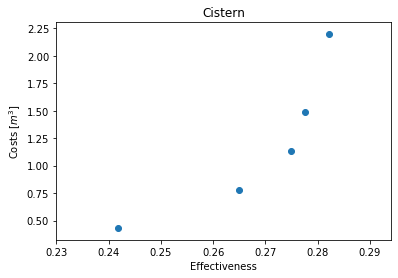

In [37]:
multiplot(effectiveness_cis_list, costs_cis_list, "Cistern")

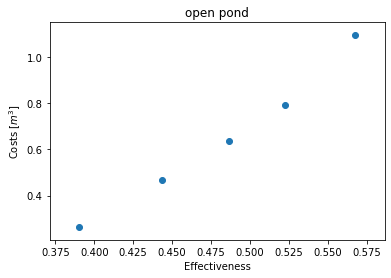

In [38]:
multiplot(effectiveness_op_list, costs_op_list, "open pond")